In [1]:
import os
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd

%matplotlib inline
# %matplotlib ipympl

# Get daily NVE discharge data

Download river discharge from NVE’s real-time station at Målselvfossen (station ID 196.35.0), located
15 km upstream of the sensor station in Målselva

Then estimate discharge at the sensor station (catchment area = 5586 km2) by area-scaling the
measured discharge at the upstream Målselvfossen station (catchment area = 3039 km2).

Note: This is an approximation, as only around half the discharge expected at the sensor site is captured by the NVE gauging station. The ungauged catchment area includes the large Altevatnet reservoir which is
regulated and is likely to show a broader and flatter increase in flow after rainfall or snowmelt than
the Målselvfossen catchment. **Future work needs to explore this, and work is underway to install a water level sensor at the Målselva sensor site**.

N.B. at the moment, don't seem to be able to download houry data through the API, so that is downloaded manually from sildre (https://sildre.nve.no/)

## User input

In [35]:
# User input
stn_id = "196.35.0"
# stn_id = "18.4.0"

# Parameters to download
par_ids = [1001]  # Daily mean discharge

# Resolution of data to download
## N.B. can't get the hourly resolution data download to work, so have done that manually via Sildre for now
resolution = 'daily'
resolution_dict = {'daily': 1440,
                   'hourly': 60,
                   'instantaneous': 0}

# Start and end dates for download
st_dt = "1900-01-01"
end_dt = "2023-09-30"

# Scale by catchment areas? If so, provide areas (km2)
area_scale = 1  # 0 or 1
area_raw = 3039.0
area_target = 5586.0

# Where to save data
download_date = '2023-10'  # (for file naming): current month and year
out_fpath = '../data/discharge/Q_målselvfossen_alldata_%s-resolution_downloaded-%s.csv' % (resolution, download_date)
out_fpath_scaled = '../data/discharge/Q_målselva_alldata_%s-resolution_area-scaled_downloaded-%s.csv' % (resolution, download_date)
out_fpath_scaled_loc = '../data/discharge/Q_målselva_%s-mean_area-scaled_2017-2022.csv' % resolution
# out_fpath = '../data/discharge/Q_Storelva_alldata_%s-resolution_downloaded-%s.csv' % (resolution, download_date)

## Download data and reformat

In [3]:
# Get daily mean discharge data
df = nivapy.da.query_nve_hydapi([stn_id], par_ids, st_dt, end_dt, resolution=1440)
df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,1965-03-23 11:00:00+00:00,17.53410,m³/s,1,3
1,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,1965-03-24 11:00:00+00:00,17.09777,m³/s,1,3
2,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,1965-03-25 11:00:00+00:00,16.66732,m³/s,1,3
3,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,1965-03-26 11:00:00+00:00,16.38360,m³/s,2,3
4,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,1965-03-27 11:00:00+00:00,16.10248,m³/s,2,3


See here for an interpretation of the correction and quality integer values: https://hydapi.nve.no/UserDocumentation/

Quality types:
* Unknown = 0
* Uncontrolled = 1
* PrimaryControlled = 2
* SecondaryControlled = 3

Correction type indicates whether the value has been corrected. e.g.:
* 0: No changes
* 1: Manual- or ice correction
* 2: Interpolation
* 3: Value computed with models or/and other series
* 4: Daily mean computed with arithmetic mean. (Only used on series where we normally should use discharge curve)
* 13: The value is calculated based on a similar station or a station close by
* 14: The value is missing, and is only calculated based on statistical information for the data series

Text(0.5, 0.98, 'Målselvfossen, 196.35.0')

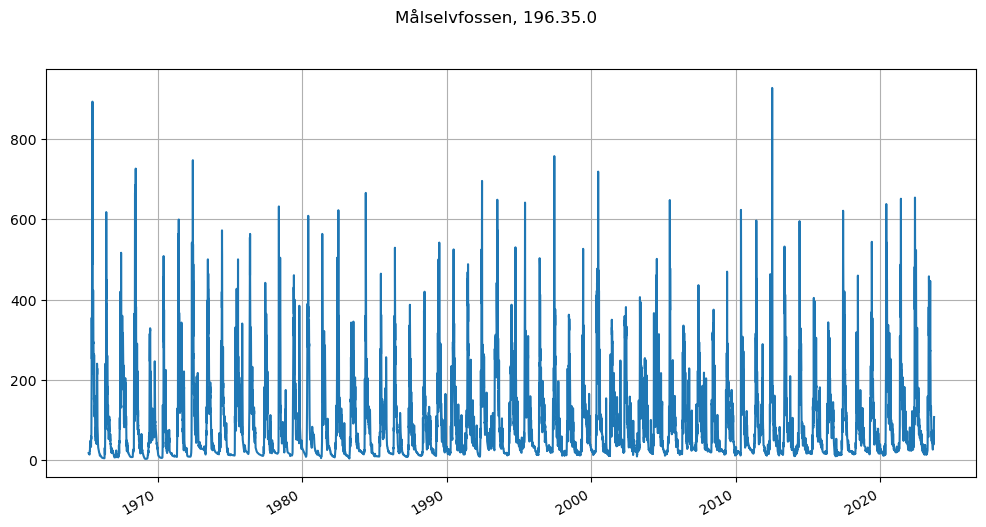

In [4]:
# Reset index
df.set_index('datetime', inplace=True)

# Quick plot
ax = plt.figure(figsize=(12, 6)).add_subplot(111)
station_name = df['station_name'][0]
df['value'].plot(ax=ax)
plt.grid(True)
plt.xlabel('')
plt.suptitle('%s, %s' % (station_name, stn_id))
# plt.savefig(r'../../data/NVE/raw_data_plots/%s-%s.png' % (station_name, stn_id))

## Annual plots

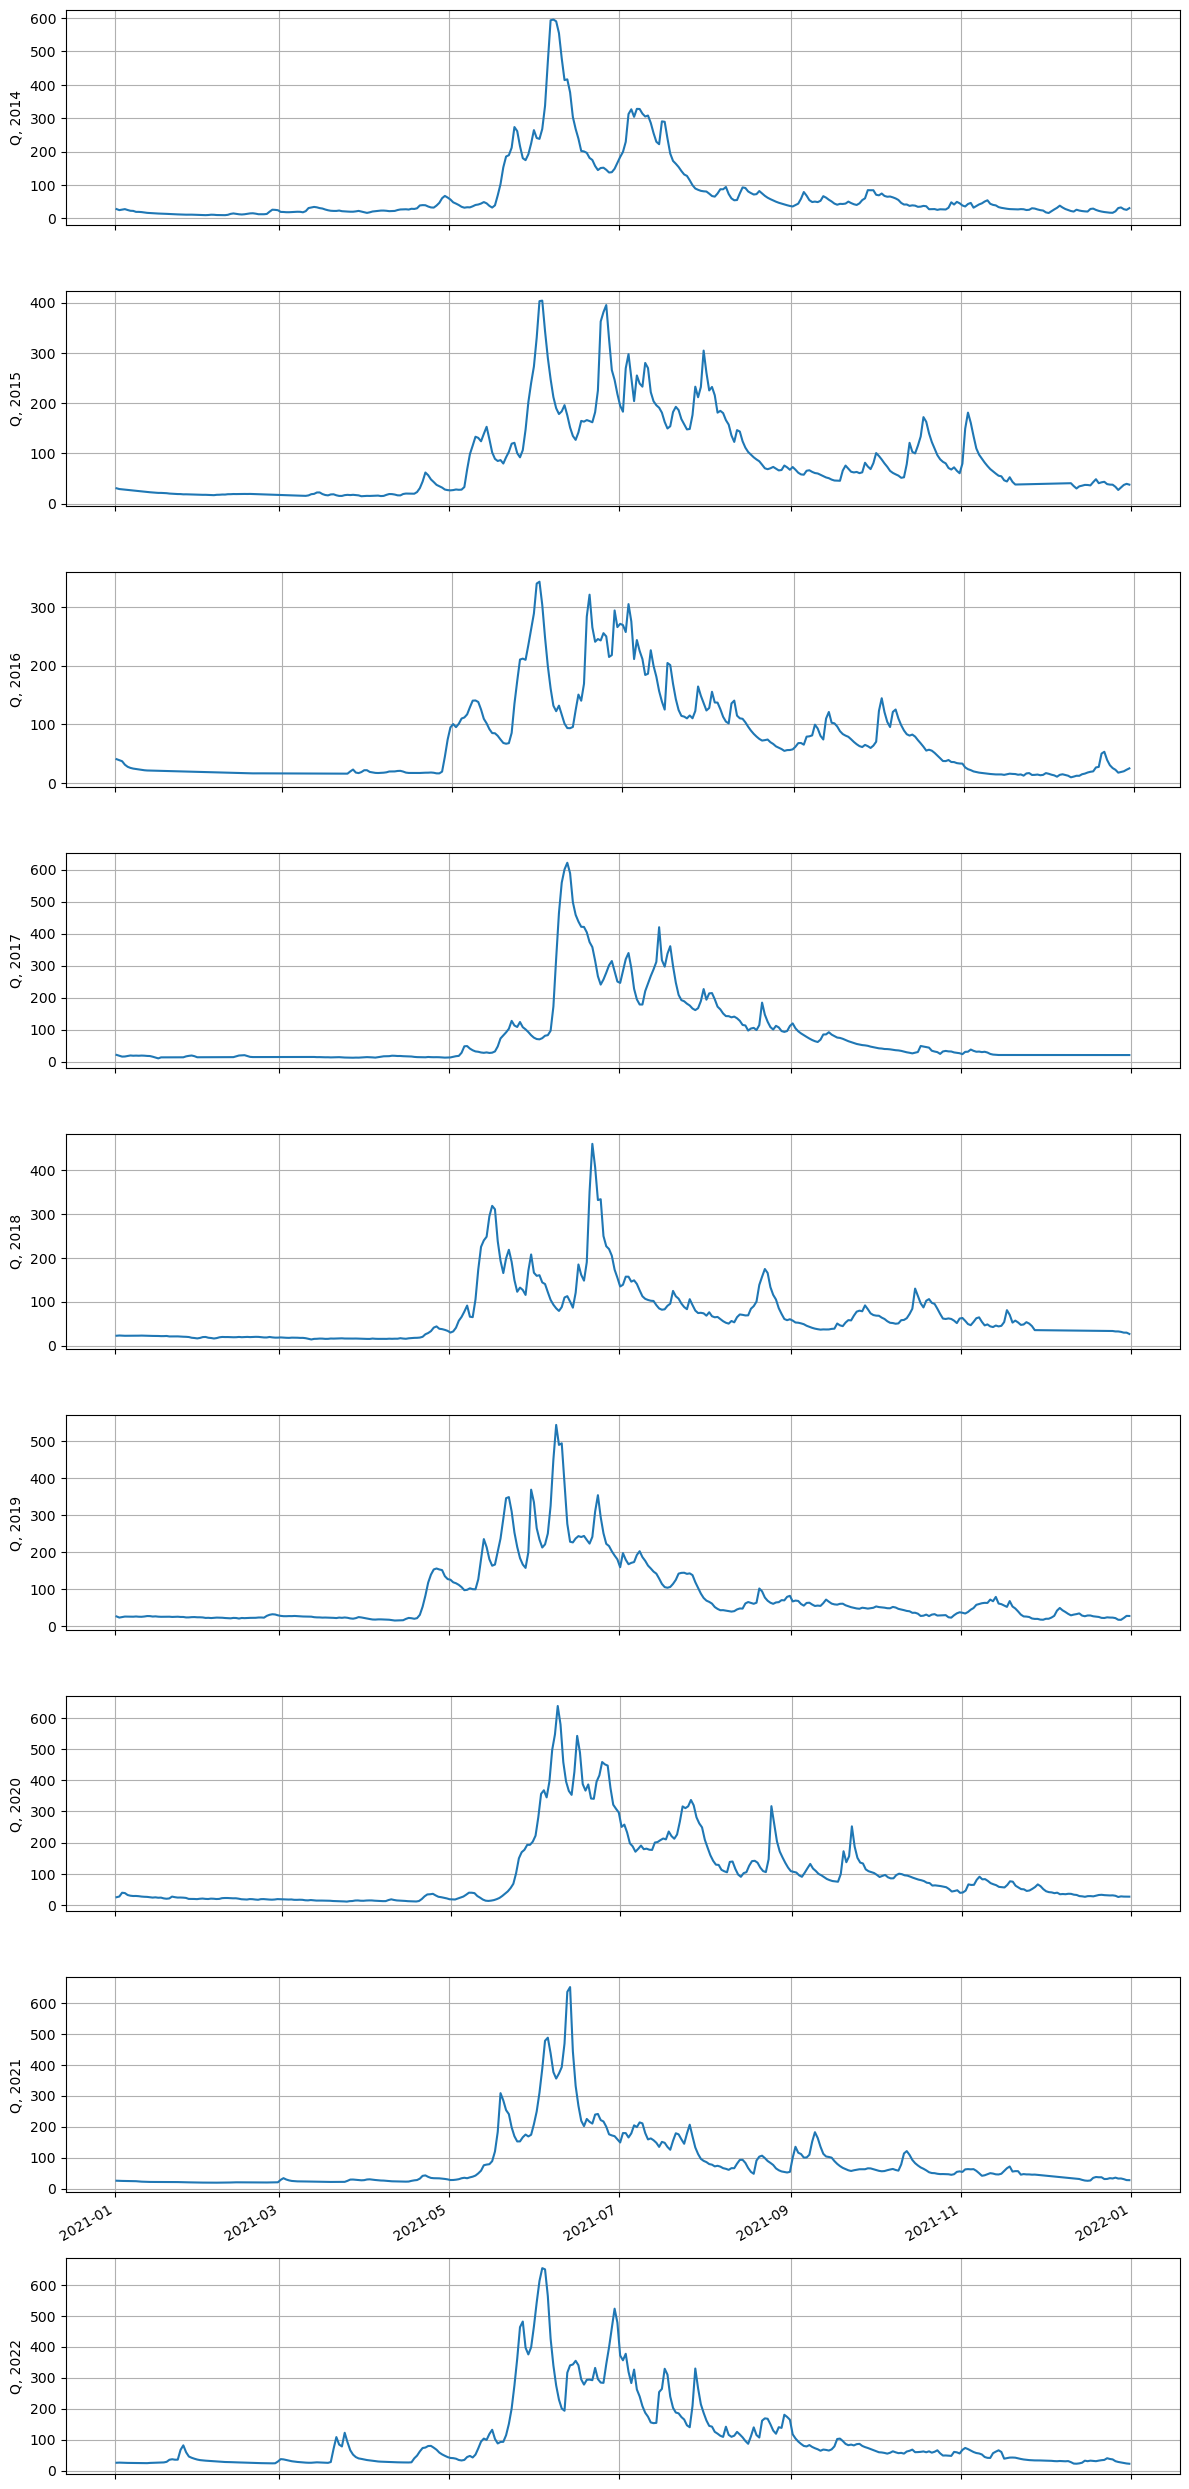

In [7]:
st_yr_plot = 2014
end_yr_plot = 2022
yr_list = list(range(st_yr_plot, end_yr_plot+1))

fig = plt.figure(figsize=(12, 25))
for i, year in enumerate(yr_list):
    ax = fig.add_subplot(len(yr_list), 1, i+1)
    df['value'].loc['%s-01-01' % year: '%s-12-31' % year].plot(ax=ax)
    plt.grid(True)
    plt.xlabel('')
    if year != end_yr_plot - 1:
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
    plt.ylabel("Q, %s" % year)

plt.tight_layout()
plt.savefig(r'../data/discharge/raw_data_plots/%s-%s_yr-by-yr.png' % (station_name, stn_id))
# plt.close()

## Area-scale

In [20]:
df.loc['2021-12-30']

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,value,unit,correction,quality
datetime,,,,,,,,,,
2021-12-30 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,27.41318,m³/s,0,3


In [32]:
if area_scale == 1:
    scaled_df = df['value'].copy() * (area_target / area_raw)
    scaled_df.name = 'Q_scaled_cumecs'
    print(df['value'].tail(), scaled_df.tail())

    # out_fpath_scaled

datetime
2023-09-25 11:00:00+00:00     77.74339
2023-09-26 11:00:00+00:00    101.15270
2023-09-27 11:00:00+00:00    107.20220
2023-09-28 11:00:00+00:00    104.76630
2023-09-29 11:00:00+00:00    107.25030
Name: value, dtype: float64 datetime
2023-09-25 11:00:00+00:00    142.900486
2023-09-26 11:00:00+00:00    185.929247
2023-09-27 11:00:00+00:00    197.048861
2023-09-28 11:00:00+00:00    192.571422
2023-09-29 11:00:00+00:00    197.137274
Name: Q_scaled_cumecs, dtype: float64


## Save

In [36]:
# Save to csv
df.to_csv(out_fpath)
scaled_df.round(5).to_csv(out_fpath_scaled)
scaled_df.round(5).loc['2017':'2022'].to_csv(out_fpath_scaled_loc)